# Text processing and Sentimental Analysis - Data Fenix
------------------

# Table of Contents

* [1. Import Libraries](#1.-Import-Libraries)
* [2. Importing data](#2.-Importing-data)
* [2. Importing data](#2.-Importing-data) 
* [3. Data Preprocessing](#3.-Data-Preprocessing)
	* [3.1 Clean Text Data](#3.1-Clean-Text-Data)
    * [3.2 Feature Engineering](#3.2-Feature-Engineering)
    * [3.3 Transform Data](#3.3-Transform-Data)
    * [3.4 Feature Selection](#3.4-Feature-Selection)
    * [3.5 Split the dataset](#3.5-Split-the-dataset)
* [4. Model Fitting](#4.-Model-Fitting)
* [5. Prediction](#5.-Prediction)
* [6. Model Evaluation](#6.-Model-Evaluation)
* [7. Feature importance](#7.-Feature-importance)

# 1. Import Libraries

In [95]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [96]:
import pandas as pd
from sklearn.utils.multiclass import unique_labels
from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

In [97]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [98]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [99]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [100]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# 2. Importing data

In [101]:
reviews_df = pd.read_csv("Hotel_Reviews.csv")
reviews_df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


In [102]:
reviews_df.shape

(515738, 17)

In [103]:
#take only the 10000
reviews_df = reviews_df.head(10000)

In [104]:
reviews_df.shape

(10000, 17)

# 3. Data Preprocessing

## 3.1 Clean Text Data

In [105]:
reviews_df["review"] = reviews_df["Negative_Review"] + reviews_df["Positive_Review"]
# create the label
reviews_df["is_bad_review"] = reviews_df["Reviewer_Score"].apply(lambda x: 1 if x < 5 else 0)
# select only relevant columns
reviews_df = reviews_df[["review", "is_bad_review"]]
reviews_df.head()

,review,is_bad_review
0,I am so angry that i made this post available...,1
1,No Negative No real complaints the hotel was g...,0
2,Rooms are nice but for elderly a bit difficul...,0
3,My room was dirty and I was afraid to walk ba...,1
4,You When I booked with your company on line y...,0


In [106]:
# remove 'No Negative' or 'No Positive' from text
reviews_df["review"] = reviews_df["review"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))

In [107]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In here we will do,
* convert text to lower cases
* remove text and remove puncutation
* remove words that contain numbers
* remove stop words
* lemmatize text
* remove words with only one letter

In [108]:
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # concatinating all
    text = " ".join(text)
    return(text)

In [109]:
reviews_df["review_clean"] = reviews_df["review"].apply(lambda x: clean_text(x))

In [110]:
sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["review"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)

## 3.2 Feature Engineering

In [111]:
# add number of characters column
reviews_df["nb_chars"] = reviews_df["review"].apply(lambda x: len(x))

# add number of words column
reviews_df["nb_words"] = reviews_df["review"].apply(lambda x: len(x.split(" ")))

In [112]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)


## 3.3 Transform Data

In [113]:
# transform each document into a vector data
doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

In [114]:
# add tf-idfs columns

tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

In [115]:
reviews_df.head()

,review,is_bad_review,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,...,word_worth,word_would,word_write,word_wrong,word_yard,word_year,word_yes,word_yet,word_young,word_zone
0,I am so angry that i made this post available...,1,angry make post available via possible site us...,0.083,0.859,0.058,-0.8589,1913,407,1.447208,...,0.0,0.042121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,No real complaints the hotel was great great ...,0,real complaint hotel great great location surr...,0.058,0.757,0.186,0.9494,611,105,0.166648,...,0.0,0.073970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Rooms are nice but for elderly a bit difficul...,0,room nice elderly bit difficult room two story...,0.111,0.671,0.218,0.8402,301,62,0.149194,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,My room was dirty and I was afraid to walk ba...,1,room dirty afraid walk barefoot floor look cle...,0.099,0.754,0.147,0.9355,1221,235,0.919626,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,You When I booked with your company on line y...,0,book company line show picture room think get ...,0.058,0.861,0.081,0.5263,774,147,0.072095,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [116]:
reviews_df.shape

(10000, 1754)

In [117]:
# Good news Vs Bad News

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


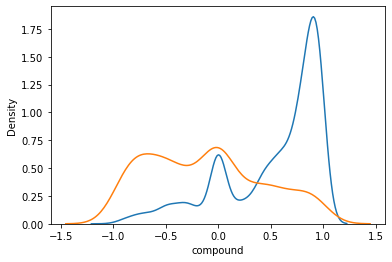

In [118]:
for x in [0, 1]:
    subset = reviews_df[reviews_df['is_bad_review'] == x]
    
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)

## 3.4 Feature Selection

In [119]:
label = "is_bad_review"
ignore_cols = [label, "review", "review_clean"]
features = [c for c in reviews_df.columns if c not in ignore_cols]

## 3.5 Split the dataset

In [120]:
X_train, X_test, y_train, y_test = train_test_split(reviews_df[features], reviews_df[label], test_size = 0.20, random_state = 42)

# 4. Model Fitting

In [121]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# 5. Prediction

#### Prediction Probability

In [122]:
y_pred = [x[1] for x in rf.predict_proba(X_test)]

In [132]:
y_pred[1:10]

[0.03, 0.0, 0.0, 0.0, 0.08, 0.11, 0.13, 0.0, 0.01]

In [136]:
predictions = pd.DataFrame(y_pred, columns= ["Pred"])

In [138]:
predictions.head(10)

,Pred
0,0.01
1,0.03
2,0.00
3,0.00
4,0.00
5,0.08
6,0.11
7,0.13
8,0.00
9,0.01


#### Predicted Values

In [123]:
y_pred_val = rf.predict(X_test)

In [133]:
y_pred_val[1:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0])

In [139]:
predictions_val = pd.DataFrame(y_pred_val, columns= ["Pred_Val"])
predictions_val.head(10)

,Pred_Val
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


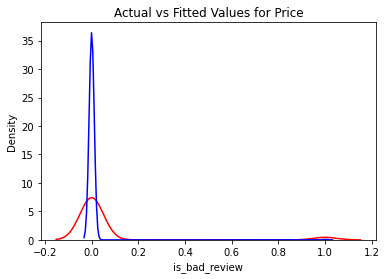

In [140]:
ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred_val, hist=False, color="b", label="Fitted Values" , ax=ax)

plt.title('Actual vs Fitted Values for Price')

plt.show()
plt.close()

# 6. Model Evaluation

In [124]:
print(f'Accurcy: {accuracy_score(y_pred_val, y_test)}')
print(f'Precision: {precision_score(y_pred_val, y_test, average="weighted")}')
print(f'Recall: {recall_score(y_pred_val, y_test, average="weighted")}')

Accurcy: 0.9445
Precision: 0.9970588221614481
Recall: 0.9445


In [125]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (8,4), fontsize=12, model='clf'):
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix,
    as a seaborn heatmap. 
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, ax=ax, fmt="d", cmap=plt.cm.Oranges)   
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.show()

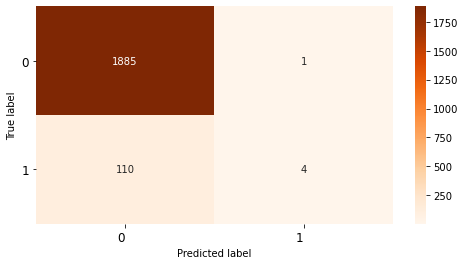

In [126]:
conf_mat = confusion_matrix(y_test, y_pred_val)
uniq_labels = unique_labels(y_test, y_pred_val)

print_confusion_matrix(conf_mat, uniq_labels)

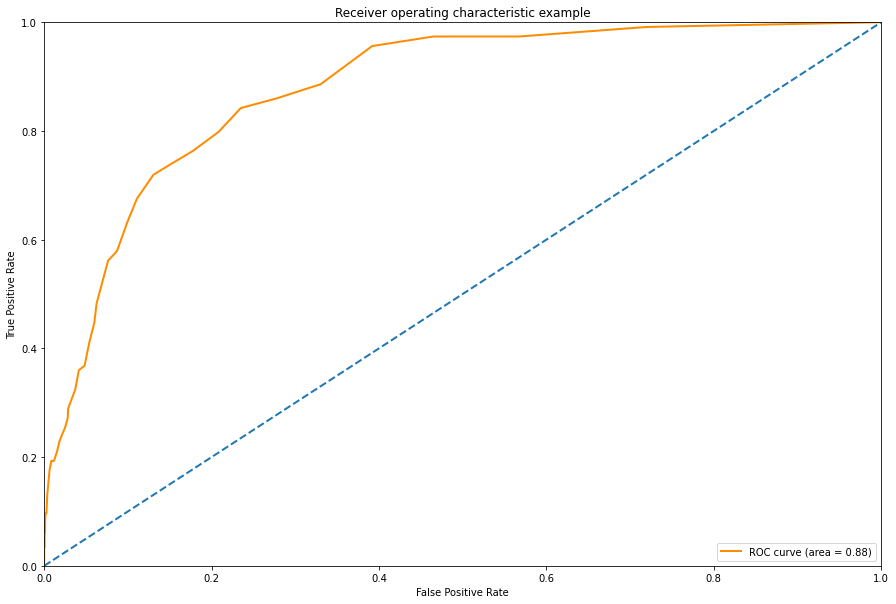

In [127]:
# ROC curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# 7. Feature importance

In [128]:
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

,feature,importance
3,compound,0.034917
2,pos,0.025572
10,doc2vec_vector_4,0.022185
9,doc2vec_vector_3,0.021706
0,neg,0.017579
7,doc2vec_vector_1,0.016958
1,neu,0.016697
6,doc2vec_vector_0,0.015785
4,nb_chars,0.015687
5,nb_words,0.015419
